# Coursework 2

Complete both tasks, using either a notebook or a Python script. Marks will be given for

* Correct implementation of algorithms to solve the tasks (10/20)
* Complete documentation of code, especially functions, and discussion of results (6/20)
* Unit tests and/or code robustness through eg assertions, as appropriate (4/20)

In [51]:
import numpy
from matplotlib import pyplot, animation
%matplotlib inline

from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
rcParams['figure.figsize'] = (10,6)

import scipy
from scipy.optimize import minimize_scalar, minimize

from IPython.core.display import HTML

from copy import deepcopy

## Agents - training the flock

A flock of boids is trained in small groups to find the "best" cohesion parameter $C$. This training is done by starting a flock of four boids at the locations $[0.5 \pm 0.25, 0.5 \pm 0.25]$ with initial velocities $[1, 1]$. The parameters $A = 5, S = 1/4$ are always used. The parameter $C$ is chosen to minimize the variance in the average width of the flock when they evolve up to $t=5$ with timesteps $\Delta t = 0.1$.

Once the flock is trained, we need to check the impact on a "proper" flock.

### Tasks

1. Given the training flock as above, use `scipy`'s `minimize_scalar` routine or equivalent to compute the best value of the parameter $C$ in the range $[0.1, 10]$. You may find the `numpy.var` routine useful for computing the variance.
2. Once you have trained the boids, create (as in the lab) a flock of $50$ agents randomly distributed within $[0, 5]^2$. Give them initial velocities of $(1, 1) + 10^{-2} {\bf v}_r$, where ${\bf v}_r$ is a random velocity with each component a uniform random number in $[0, 1]$. Evolve the flock using timesteps of $0.05$ for $200$ steps and plot the flock behaviour. Also plot the "width" of the flock.

In [2]:
# the initial time & time step
t = 5
dt = 0.1

In [147]:
def set_up_locations4():
    """
    Function that creates the initial flock in order to obtain the C for minimum variance.
    
    @Parameters
    NONE
    
    @Returns
    flock - np array
            array containing the initial position of the the test flock.
    """
    flock = numpy.zeros([4, 2])
    flock[0] = [0.75, 0.75]
    flock[1] = [0.75, 0.25]
    flock[2] = [0.25, 0.75]
    flock[3] = [0.25, 0.25]
    
    return flock

In [152]:
class Agent(object):
    """
    Class that defines the agent in a crowd. 
    The agent will assert it's loccation against a set of neighbours, and move with the group.
    
    Main author: Dr. Ian Hawke. 
    """
    def __init__(self, location, velocity, C=1, A=5, S=0.25):
        """
        Initialisation of the class.
        
        @parameters
        location - np array (2)
                the location of the agent as x & y coordinates
                
        velocity - np array (2)
                the velocity of the agent on x & y axis
                
        C - float
            parameters used in calculating the direction of movement
            
        A - float
            parameters used in calculating the direction of movement
        
        S - float
            parameters used in calculating the direction of movement
        """
        assert type(location) == numpy.ndarray, \
            "Location is not a np array."
        assert location.shape == (2,), \
            "location is not the correct shape (2,). It is {}".format(location.shape)
        assert type(velocity) == numpy.ndarray, \
            "velocity is not a np array."
        assert velocity.shape == (2,), \
            "velocity is not the correct shape (2,). It is {}".format(location.shape)
        
        assert type(C) == int or type(C) == float or type(C) == numpy.float64, \
            "C is not the proper format. It is {}".fomart(type(C))
        assert type(A) == int or type(A) == float or type(A) == numpy.float64, \
            "A is not the proper format. It is {}".fomart(type(A))
        assert type(S) == int or type(S) == float or type(S) == numpy.float64, \
            "S is not the proper format. It is {}".fomart(type(S))
            
        self.location = numpy.array(location)
        self.velocity = numpy.array(velocity)
        #set up the cost function 
        self.cost = lambda theta, theta_z, theta_V, theta_zmin, dzmin : \
            -(C * numpy.cos(theta - theta_z) + A * numpy.cos(theta - theta_V) - \
            S * numpy.cos(theta - theta_zmin) / dzmin**2)
        
    def step(self, dt):
        """
        Method which updates the position of the agent based on the new velocity.
        
        @parameters
        dt - float
            time-step for which the movement is approximated.
        
        @return
        self.location - np array (2,)
            not specifically returned, but updated. contains the new location of the agent. 
        """
        self.location += dt * self.velocity
        
    def steer(self, neighbours):
        """
        Method enabling the agent to steer (change the velocity vector) in the general direction
        of the flow of the closest meighbours. The method analyses the neighbours, computes the 
        movement angle in which the agent should move, and updates the velocity.
        
        @parameters
        neighbours - np array (N, 2, 2) or list
            list / array containing the neighbouring agents. 
            
        @returns
        None
        UPDATE! : self.velocity - np array (2)
                        the velocity array is update based n the direction of the flow. 
        """
        assert type(neighbours) == list or type(neighbours) == numpy.ndarray, \
            "neighbours not the proper type. it is {}".format(type(neighbours))
            
        if type(neighbours) == list:
            assert len(neighbours) != 0, \
                "Neighbours is an empty list. Fix it!"
        elif type(neighbours) == numpy.ndarray:
            assert neighbours.shape != (0,), \
                "Neighbours is an empty array. Fix it!"
                
        N = len(neighbours)
        if N:
            flock_locations = numpy.zeros((N,2))
            flock_velocities = numpy.zeros((N,2))
            for i in range(N):
                flock_locations[i,:] = neighbours[i].location
                flock_velocities[i,:] = neighbours[i].velocity
            # Average properties
            z = numpy.mean(flock_locations, axis=0)
            V = numpy.mean(flock_velocities, axis=0)
            # Direction to average location
            dz = z - self.location
            theta_z = numpy.arctan2(dz[1], dz[0])
            # Direction of average velocity
            theta_V = numpy.arctan2(V[1], V[0])
            # Separation to all other boids
            dz = flock_locations - self.location
            # Closest neighbour
            zmin_i = numpy.argmin(numpy.linalg.norm(dz, 2, axis=1))
            # Separation and angle
            dzmin = numpy.linalg.norm(dz[zmin_i, :], 2)
            theta_zmin = numpy.arctan2(dz[zmin_i, 1], dz[zmin_i, 0])

            theta_min = minimize_scalar(self.cost, bracket = (-1.5*numpy.pi, 1.5*numpy.pi), 
                                        args=(theta_z, theta_V, theta_zmin, dzmin))
            theta = theta_min.x
            speed = numpy.linalg.norm(self.velocity, 2)
            self.velocity[0] = speed * numpy.cos(theta)
            self.velocity[1] = speed * numpy.sin(theta)

In [149]:
from copy import deepcopy

class Flock(object):
    """
    Class that creates, contains &  works on a flock. 
    
    A flock is defined as a multitude of objects, each with a location (x & y position) and 
    velocity (in x & y directions). THe objects interact with each other, creating a movement
    relative to other close objects. 
    
    Main author: Dr. Ian Hawke.
    """
    def __init__(self, locations, velocities, C, rl=1):
        """
        Initialisation of FLOCK.
        
        @parameters
        locations - np array (N, 2)
                np array containing the positions of N objects in x & y coordinates.
                
        velocities - np array (N, 2)
                np array containing the velocities of N objects in x & y directions
        
        C - float / int
            parameter used in the cost function that defines each object
            
        rl - float / int
            the distance between points past which the interaction is not considered anymore
        """
        assert type(locations) == list or type(locations) == numpy.ndarray, \
            "locations not the proper type. it is {}".format(type(locations))
        if type(locations) == list:
            assert len(locations) != 0, \
                "locations is an empty list. Fix it!"
        elif type(locations) == numpy.ndarray:
            assert locations.shape != (0,), \
                "locations is an empty array. Fix it!"
                
        assert type(velocities) == list or type(velocities) == numpy.ndarray, \
            "velocities not the proper type. it is {}".format(type(velocities))
        if type(velocities) == list:
            assert len(velocities) != 0, \
                "velocities is an empty list. Fix it!"
        elif type(velocities) == numpy.ndarray:
            assert velocities.shape != (0,), \
                "velocities is an empty array. Fix it!"
                
        assert type(C) == int or type(C) == float or type(C) == numpy.float64, \
            "C is not the correct type. It is {}.".format(type(C))
        
        self.locs = numpy.array(locations)
        self.vels = numpy.array(velocities)
        self.rl = rl
        self.agents = []
        #create & store the agents
        for location, velocity in zip(locations, velocities):
            self.agents.append(Agent(location, velocity, C=C))
    
    def step(self, dt):
        """
        Method that takes each agent in the list, compares it with the other agents to get
        the close neighbours, moves the respective agent in the direction of its neighbours and 
        updates its location. 
        
        @parameters
        dt - float
            time-step for which the movement takes place
            
        @returns
        UPDATE! agent.location - np array 2
                        array containing the position of an agent. Each agent is updated
        UPDATE! agent.velocity - np array 2
                        array containing the velocity of an agent. Each agent is updated
        """
        assert type(dt) == int or type(dt) == float or type(dt) == numpy.float64, \
            "dt is not the right type. Current type is: {}.".format(type(dt))
        current_agents = []
        for agent in self.agents:
            current_agents.append(deepcopy(agent))  #create deepcopy so the 
        for i, agent in enumerate(self.agents):
            neighbours = []
            for j, other_agent in enumerate(current_agents):
                if i != j:
                    separation = agent.location - other_agent.location
                    distance = numpy.linalg.norm(separation, 2)
                    if (distance < self.rl):
                        neighbours.append(other_agent) #this way, you use the old agents, and not update the new ones
            agent.steer(neighbours)
            agent.step(dt)
    
    def locations(self):
        """
        Method that returns the locations of all agents in the flock.
        
        @Return
        locs - np array (N, 2)
            array containing the current locations of all agents in the flock. 
        """
        for i, agent in enumerate(self.agents):
            self.locs[i,:] = agent.location
        assert type(self.locs) == numpy.ndarray, \
            "self.locs is not the proper type. It is: {}".format(type(self.locs))
        assert self.locs.shape != (0,), \
            "self.locs cannot be a 0 array."
        return self.locs
    
    def velocities(self):
        """
        Method that returns the velocities of all agents in the flock.
        
        @Return
        vels - np array (n, 2)
            array containng the current velocities of all agents in the flock
        """
        for i, agent in enumerate(self.agents):
            self.vels[i,:] = agent.velocity
        assert type(self.vels) == numpy.ndarray, \
            "self.vels is not the proper type. It is: {}".format(type(self.vels))
        assert self.vels.shape != (0,), \
            "self.vels cannot be a 0 array."
        return self.vels
    
    def average_location(self):
        """
        Method that returns the average location of the flock, relative to a (0, 0) origin.
        
        @return
        average_loc - np array (2,)
            array giving the average location of the entire flock.
        """
        locations = self.locations()
        average_loc = numpy.mean(locations, axis=0)
        assert type(average_loc) == numpy.ndarray, \
            "average_loc is not the proper type. It is: {}".format(type(average_loc))
        assert average_loc.shape == (2,), \
            "average_loc is not the proper shape. it is {}.".format(average_loc.shape)
        return average_loc
    
    def average_velocity(self):
        """
        Method that returns the average velocity of the flock.
        
        @return
        average_vel - np array (2,)
            array containing the average velocity of the flock.
        """
        velocities = self.velocities()
        average_vel = numpy.mean(velocities, axis=0)
        assert type(average_vel) == numpy.ndarray, \
            "average_vel is not the proper type. It is: {}".format(type(average_vel))
        assert average_vel.shape == (2,), \
            "average_vel is not the proper shape. it is {}.".format(average_vel.shape)
        return average_vel
    
    def average_width(self):
        """
        Method returning the average width of the flock. 
        
        @return
        width - float
            the avearge width of the flock. 
        """
        locations = self.locations()
        average_location = self.average_location()
        separations = numpy.abs(locations-average_location)
        width = numpy.mean(numpy.linalg.norm(separations, 2, axis=1))
        assert type(width) == float or type(width) == numpy.float64, \
            "width was not created properly. its type is: {}".format(type(width))
        assert width != 0, \
            "width cannot be 0. something went wrong."
        return width

In [150]:
def min_width_C(C):
    """
    Function that takes the value of C of the cost function and passes it to the flock. This
    function then uses the test flock to evaluate its width over a period of 5s, with a time-step
    of 0.1s. 
    The values of the average width are recorded, and the variance of the average width is 
    returned. 
    In addition, this function will be used to calculate the value of C for which the minimum
    width variance will be obtained. 
    
    @Parameters
    C - float
        cost function parameter used to minimise the variance in the flock's width
        
    @Return
    average flock width variance - float
        average flock width variance required to be minimised.
    """
    assert type(C) == int or type(C) == float or type(C) == numpy.float64, \
        "C is not the right type. The current type is: {}.".format(type(C))
    locations = set_up_locations4()
    vels = numpy.ones_like(locations)
    flock = Flock(locations, vels, C)
    N = int(t/dt)
    width = numpy.zeros(N)
    for i in range(N):
        flock.step(dt)
        width[i] = flock.average_width()
    assert (width != 0).all(), \
        "One or more values of the average width is 0. This is not correct."
    return np.var(width)

In [158]:
# set up test flock
locations = set_up_locations4()
vels = np.ones_like(locations)

# initialise and compute the C for which the minimum width variance is obtained.
C_min = minimize_scalar(min_width_C, bounds=[(0.1, 10)]).x
print("The value of C for which the minimum width variance is obtained is: \nC = {}.".format(C_min))

The value of C for which the minimum width variance is obtained is: 
C = 0.758919483905994.


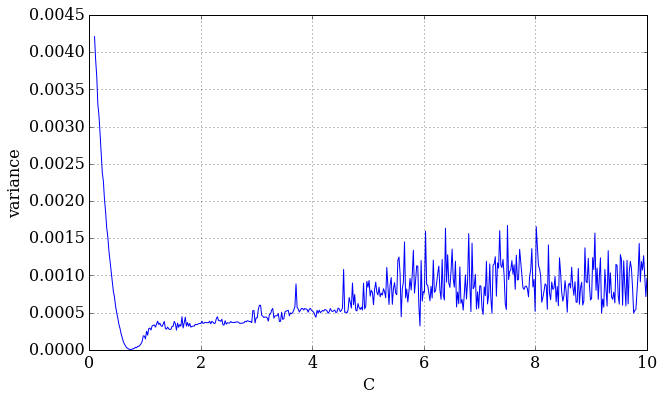

In [125]:
# sanity check plot
Cs = numpy.linspace(0.1, 10, 500)
vw = numpy.zeros(500)

# compute the variance for the C domain.
for i in range(500):
    vw[i] = min_width_C(Cs[i])

# plot results
pyplot.plot(Cs, vw)
pyplot.xlabel("C")
pyplot.ylabel("variance")
pyplot.title("Variance distribution a")
pyplot.grid(True)
pyplot.show()

In [133]:
def flock_animation(flock, dt, frames=10, xlim=(-0.1, 5), ylim=(-0.1, 5)):
    """
    Function which takes a flock of boids, and plots & animates their behaviour. 
    
    The function animates their behaviour, as they move on x & y axis over a set
    number of frames. Also, it displays the average width of the flock.
    
    @parameters
    flock - class @ __main__.Flock
        class containing all the agents from a flock, with their velocity & position. Has diferent methods
        which can be called
    
    dt - float
        timestep for which the animation step will proceed
        
    frames - int
        number of frames for which the animation will take places
        
    xlim - list
        list containing the boundaries on X axis for the animation
        
    ylim - list
        list containing the boudaries on Y axis for the animation
        
    @returns
    animation - matplotlib.animation.FuncAnimation
        the animation of the movement of the flock which will be displayed 
        
    Main author: Dr. Ian Hawke.
    """
    assert isinstance(flock, Flock), \
        "flock is not the Flock class. It is: {}".format(type(flock))
    assert type(dt) == int or type(dt) == float or type(dt) == numpy.float64, \
        "dt is not the recognised type. It is: {}.".format(type(dt))
        
    # produce the positions of the agents in the flock over the number of frames
    locations = [deepcopy(flock.locations())]
    ave_width = [flock.average_width()]
    ave_loc = [flock.average_location()]
    ave_vel = [flock.average_velocity()]
    times = np.arange(0.0, frames*dt, dt)
    for i in range(frames):
        flock.step(dt)
        locations.append(deepcopy(flock.locations()))
        ave_width.append(flock.average_width())
        ave_loc.append(flock.average_location())
        ave_vel.append(flock.average_velocity())
    
    # gather the dimensions for the average width plot
    max_width = max(ave_width)
    min_width = min(ave_width)
    d_width = max_width - min_width
    
    #stor plotting the movement of particles
    fig = pyplot.figure()
    ax1 = fig.add_subplot(121)
    ax1.set_xlim(xlim[0], xlim[1])
    ax1.set_ylim(ylim[0], ylim[1])
    points, = ax1.plot([], [], 'ro')
    ax1.set_xlabel("$x$")
    ax1.set_ylabel("$y$")
    #start second plot of average width
    ax2 = fig.add_subplot(122)
    width, = ax2.plot([], [], 'b-')
    ax2.set_xlabel("$t$")
    ax2.set_ylabel("Average width of flock")
    ax2.set_xlim(0.0, dt*frames)
    ax2.set_ylim(min_width-0.1*d_width, max_width+0.1*d_width)
    fig.tight_layout()
    pyplot.close()

    def init():
        """
        Method that initialises the starting positions of the particles & the avg width for the animation
        """
        points.set_data([], [])
        width.set_data([], [])
        """
        loc.set_data([], [])
        vel.set_data([], [])"""
        return (points, width)

    def animate(i):
        """
        Method that creates the ith frame for the animation.
        
        @parameter 
        i - int
            the frame number of the animation
        """
        points.set_data(locations[i][:,0], locations[i][:,1])
        width.set_data(times[:i+1], ave_width[:i+1])
        """loc.set_data([ave_loc[i][0]], [ave_loc[i][1]])
        vel.set_data([ave_vel[i][0]], [ave_vel[i][1]])"""
        return (points, width)
    
    return animation.FuncAnimation(fig, animate, init_func=init, interval=100, frames=frames, blit=True)

In [134]:
# animation for the test flock
flock = Flock(locations, vels, C=C_min)
HTML(flock_animation(flock, 0.1, int(t/dt), xlim=(-20.0,20.00), ylim=(-20.0,20)).to_html5_video())

In [126]:
# initialise the random 50 positions & velocities for the agents
locs_flock = numpy.random.random([50, 2]) * 5
vels_flock = numpy.array([1., 1.]) + 10**-2 * numpy.random.random([50, 2])

# create the random flock with the value of C obtained previously
flock_rand = Flock(locs_flock, vels_flock, C_min)

In [127]:
# animate the flock
HTML(flock_animation(flock_rand, 0.05, 200, xlim=(-20.0,20.0), ylim=(-20.0,20)).to_html5_video())

## Finite elements - the big G

Solve the heat equation

$$
  \nabla^2 T + f(x, y) = 0
$$

on the domain $\Omega$, where $\Omega$ looks like the figure below:

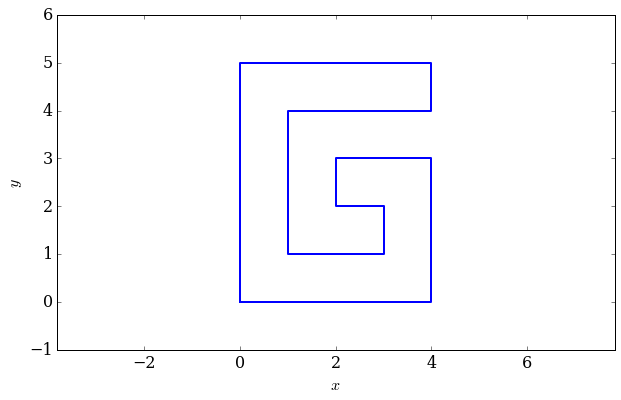

In [9]:
domain = numpy.array([[0.0, 0.0], [4.0, 0.0], [4.0, 3.0], [2.0, 3.0], [2.0, 2.0], [3.0, 2.0], [3.0, 1.0],
                      [1.0, 1.0], [1.0, 4.0], [4.0, 4.0], [4.0, 5.0], [0.0, 5.0], [0.0, 0.0]])
pyplot.figure(figsize=(10,6))
pyplot.plot(domain[:,0],domain[:,1], lw=2)
pyplot.axis('equal')
pyplot.xlim(-1,5)
pyplot.ylim(-1,6)
pyplot.xlabel(r"$x$")
pyplot.ylabel(r"$y$")
pyplot.show()

The temperature $T$ is fixed to be $1$ along the whole right boundary where $x=4$. On all other boundaries the normal derivative of the temperature vanishes. The heat source $f(x, y)$ is given by

$$
  f = \exp(-(x^2 + y^2)).
$$

### Tasks

1. Using the grid generation function below, and a finite element algorithm using linear elements as in the lab, compute and plot the solution of the heat equation with triangles of side-length $1/2$ and $1/16$.

#### Grid generation

In [10]:
def find_node_index_of_location(nodes, location):
    """
    Given all the nodes and a location (that should be the location of *a* node), return the index of that node.
    
    Parameters
    ----------
    
    nodes : array of float
        (Nnodes, 2) array containing the x, y coordinates of the nodes
    location : array of float
        (2,) array containing the x, y coordinates of location
    """
    dist_to_location = numpy.linalg.norm(nodes - location, axis=1)
    return numpy.argmin(dist_to_location)
                

def generate_g_grid(side_length):
    """
    Generate a 2d triangulation of the letter G. All triangles have the same size (right triangles, 
    short length side_length)
    
    Parameters
    ----------
    
    side_length : float
        The length of each triangle. Should be 1/N for some integer N
    
    Returns
    -------
    
    nodes : array of float
        (Nnodes, 2) array containing the x, y coordinates of the nodes
    IEN : array of int
        (Nelements, 3) array linking element number to node number
    ID : array of int
        (Nnodes,) array linking node number to equation number; value is -1 if node should not appear in global arrays.
    """
    x = numpy.arange(0, 4+0.5*side_length, side_length)
    y = numpy.arange(0, 5+0.5*side_length, side_length)
    X, Y = numpy.meshgrid(x,y)
    potential_nodes = numpy.zeros((X.size,2))
    potential_nodes[:,0] = X.ravel()
    potential_nodes[:,1] = Y.ravel()
    xp = potential_nodes[:,0]
    yp = potential_nodes[:,1]
    nodes_mask = numpy.logical_or(numpy.logical_and(xp>=2,numpy.logical_and(yp>=2,yp<=3)),
                                  numpy.logical_or(numpy.logical_and(xp>=3,yp<=3),
                                                   numpy.logical_or(xp<=1,
                                                                    numpy.logical_or(yp<=1, yp>=4))))
    nodes = potential_nodes[nodes_mask, :]
    ID = numpy.zeros(len(nodes), dtype=numpy.int)
    n_eq = 0
    for nID in range(len(nodes)):
        if numpy.allclose(nodes[nID,0], 4):
            ID[nID] = -1
        else:
            ID[nID] = n_eq
            n_eq += 1
    inv_side_length = int(1 / side_length)
    Nelements_per_block = inv_side_length**2
    Nelements = 2 * 14 * Nelements_per_block
    IEN = numpy.zeros((Nelements,3), dtype=numpy.int)
    block_corners = [[0,0], [1,0], [2,0], [3,0],
                     [0,1],               [3,1],
                     [0,2],        [2,2], [3,2],
                     [0,3],
                     [0,4], [1,4], [2,4], [3,4]]
    current_element = 0
    for block in block_corners:
        for i in range(inv_side_length):
            for j in range(inv_side_length):
                node_locations = numpy.zeros((4,2))
                for a in range(2):
                    for b in range(2):
                        node_locations[a+2*b,0] = block[0] + (i+a)*side_length
                        node_locations[a+2*b,1] = block[1] + (j+b)*side_length
                index_lo_l = find_node_index_of_location(nodes, node_locations[0,:])
                index_lo_r = find_node_index_of_location(nodes, node_locations[1,:])
                index_hi_l = find_node_index_of_location(nodes, node_locations[2,:])
                index_hi_r = find_node_index_of_location(nodes, node_locations[3,:])
                IEN[current_element, :] = [index_lo_l, index_lo_r, index_hi_l]
                current_element += 1
                IEN[current_element, :] = [index_lo_r, index_hi_r, index_hi_l]
                current_element += 1
    return nodes, IEN, ID

In [11]:
nodes, IEN, ID = generate_g_grid(1/2)

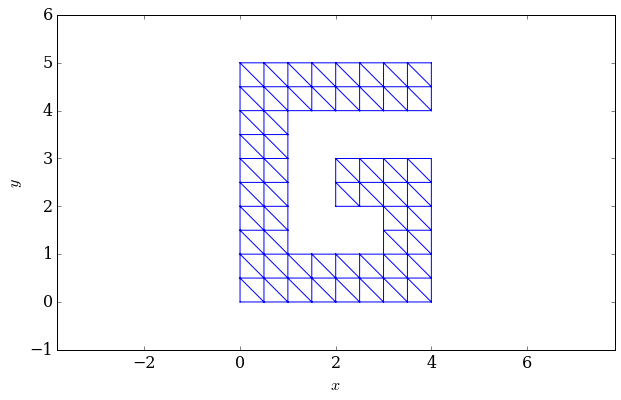

In [12]:
pyplot.figure(figsize=(10,6))
pyplot.triplot(nodes[:,0], nodes[:,1], triangles=IEN, lw=1)
pyplot.axis('equal')
pyplot.xlim(-1,5)
pyplot.ylim(-1,6)
pyplot.xlabel(r"$x$")
pyplot.ylabel(r"$y$")
pyplot.show()